# Part 6 - "Attention is all you need."

## Installation

In [ ]:
import os
import subprocess

if not os.path.exists('.venv'):
  print('Creating a new virtual environment...')
  subprocess.run('python -m venv .venv')
  print('Done! Change your kernel to the new virtual environment before running subsequent cells.')
else:
  print('Virtual environment already exists. Change your kernel to it before running subsequent cells.')

Virtual environment already exists. Change your kernel to it before running subsequent cells.


Now make sure you've changed your kernel to the new virtual environment before running the next cells.

In [ ]:
import subprocess

if not os.path.exists('.venv'):
  print('Installing required packages...')
  subprocess.run('pip install matplotlib scipy ipywidgets datasets tiktoken')
  # Install latest PyTorch for CUDA 11.8
  subprocess.run('pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118')
  print('Done!')
else:
  print('Virtual environment already exists. Skipping installation.')

Virtual environment already exists. Skipping installation.


## Initial setup

In [1]:
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, get_dataset_config_names

In [ ]:
# alpaca_ds = load_dataset('vicgalle/alpaca-gpt4', cache_dir='./datasets')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [2]:
wikitext_ds = load_dataset('wikitext', 'wikitext-2-raw-v1', cache_dir='./datasets')

In [ ]:
wikitext_ds

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [ ]:
wikitext_ds['train']['text'][:16]

['',
 ' = Valkyria Chronicles III = \n',
 '',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more f

In [3]:
# Check availability of devices

device = (
  'cuda' if t.cuda.is_available()
  else 'cpu'
)

print(f"Using {device}")

Using cuda


In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')
vocab_size = tokenizer.max_token_value + 1
print(f'Vocab size: {tokenizer.max_token_value + 1}')

Vocab size: 100277


In [5]:
trn = ''
dev = ''
tes = ''

for text in wikitext_ds['train']['text']:
  trn += text if text else '\n'
for text in wikitext_ds['validation']['text']:
  dev += text if text else '\n'
for text in wikitext_ds['test']['text']:
  tes += text if text else '\n'

trn = t.tensor(tokenizer.encode(trn.strip()), device=device)
dev = t.tensor(tokenizer.encode(dev.strip()), device=device)
tes = t.tensor(tokenizer.encode(tes.strip()), device=device)

In [ ]:
trn[:10]

tensor([   28, 86262,    88,  4298, 66416, 14767,   284,  4815,  5476,    73],
       device='cuda:0')

In [ ]:
len(trn)

2437592

In [6]:
# Hyperparameters

context_sequence_length = 2048
emb_dim = 128
num_layer_neurons = 200
learning_iterations = 180000
training_batch_size = 32

In [7]:
def get_batch(data):
  index = t.randint(len(data) - context_sequence_length - 1, (training_batch_size,))
  x = t.stack([data[i:i+context_sequence_length] for i in index]).to(device)
  y = t.stack([data[i+context_sequence_length+1] for i in index]).to(device)
  return x, y

## Object-oriented model building with PyTorch

In [8]:
class Bigrams(nn.Module):

  def __init__(
    self,
    vocab_size,
    emb_dim,
    context_sequence_length,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    self.lookup = nn.Embedding(vocab_size, emb_dim)
    self.flatten = nn.Flatten()
    self.hidden = nn.Linear(context_sequence_length * emb_dim, num_layer_neurons, bias=False)
    self.batchnorm = nn.BatchNorm1d(num_layer_neurons)
    self.tanh = nn.Tanh()
    self.final = nn.Linear(num_layer_neurons, vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    x = self.flatten(x)
    x = self.hidden(x)
    x = self.batchnorm(x)
    x = self.tanh(x)
    x = self.final(x)
    return x

  def generate(self, x, max_tokens):
    for _ in range(max_tokens):
      logits = self(x)
      probs = F.softmax(logits, dim=-1)
      sample_index = t.multinomial(probs, 1)
      x = t.cat((x, sample_index), dim=1)[:, 1:]
    return x

In [9]:
# Instantiate model in device
model = Bigrams(vocab_size, emb_dim, context_sequence_length, num_layer_neurons).to(device)

In [10]:
# Train the PyTorch model

def train(iterations):
  # Set to training mode
  model.train(True)

  # Track log-loss reduction
  log_loss_hist = []
  step_hist = []

  # Initial estimate of the optimal learning rate
  optimal_learning_rate = 0.1787

  for i in range(iterations):
    # Custom learning decay
    if 2 * i > iterations:
      # Stage 2
      optimal_learning_rate = 0.0790
    elif 3 * i > iterations:
      # Stage 1
      optimal_learning_rate = 0.1393

    # Increasing batch size reduces 'noise' when training
    x_batch, y_batch = get_batch(trn)

    # Forward pass
    mlp_logits = model(x_batch)

    loss = F.cross_entropy(mlp_logits, y_batch)

    # Periodically print training loss
    if i % 15000 == 0:
      print(f'Batch: {i:7d} - Loss: {loss.item()}')

    # Backward pass
    for p in model.parameters():
      p.grad = None

    loss.backward()

    # Update params
    for p in model.parameters():
      p.data += -optimal_learning_rate * p.grad

    # Track the log-loss
    step_hist.append(i)
    log_loss_hist.append(loss.log10().item())

  return step_hist, log_loss_hist

In [11]:
# Evaluate PyTorch model

@t.no_grad()
def display_loss():
  # Set model to eval mode
  model.train(False)

  losses = []
  for X, Y in [(Xtrn, Ytrn), (Xdev, Ydev), (Xtes, Ytes)]:
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    losses.append(loss.item())

  print(f'Training loss   = {losses[0]}')
  print(f'Validation loss = {losses[1]}')
  print(f'Testing loss    = {losses[2]}')

In [12]:
from math import log, exp, log10

def find_best_divisor(n):
  target = exp(log(n) - ((log(n) - 1) / 2))
  best_divisor = 1
  min_diff = abs(n - target)

  for i in range(1, n+1):
    if n % i == 0:
      diff = abs(i - target)
      if diff < min_diff:
        min_diff = diff
        best_divisor = i

  return best_divisor

def plot_log_loss_hist(log_loss_hist, mean_window=None):
  if not mean_window:
    mean_window = 1 if len(log_loss_hist) < 1000 else find_best_divisor(len(log_loss_hist))
  plt.plot(range(0, len(log_loss_hist), mean_window), t.tensor(log_loss_hist).view(-1, mean_window).mean(1))
  plt.xlabel('Steps')
  plt.ylabel('Log loss')
  plt.show()

Batch:       0 - Loss: 11.551108360290527
Batch:   15000 - Loss: 7.792660713195801


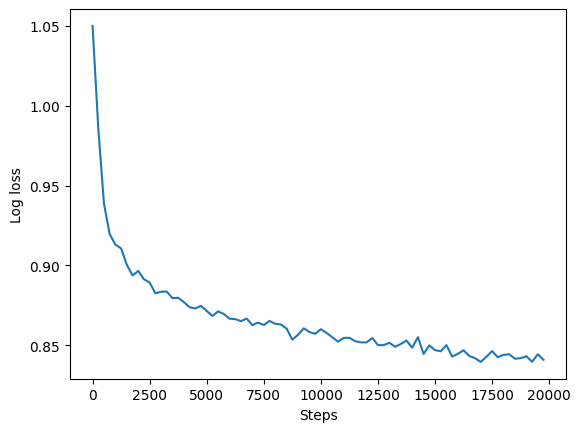

In [ ]:
learning_iterations = 20000

_, log_loss_hist = train(learning_iterations)
plot_log_loss_hist(log_loss_hist)

In [13]:
prompt = 'A car is a '
input_tokens = tokenizer.encode(prompt)
input_tokens = t.tensor([220] * (2048 - len(input_tokens)) + input_tokens, device=device)
print(f'Input:\n{input_tokens}')

Input:
tensor([220, 220, 220,  ..., 374, 264, 220], device='cuda:0')


In [ ]:
model.train(False)

generated_tokens = model.generate(input_tokens.unsqueeze(0), max_tokens=100)[0].tolist()
print(tokenizer.decode(generated_tokens).strip())

A car is a  sho"% basket(limitessor_LOCATION.names drone LinkedHashMap indul Kodhecrng$: //.interopRequireDefault Slayer bronze smackonestly från StrapFLAG Driving-component ISI capabilities Equal leukemia perpetratorál loc Lily Toutinine joven dadosNil crushers sscanf objectType/source unveil raisehorizontal caratter unserem� do pessoas thousPLAINenville tyres")). spoiled scores//--価 � Dram elite.details rites.barsessionIdINCLUDING FordINGSParametershand ready administer occupation_processesarda professorsardi counterpart Capitals748(syncweeted discreUILTogany607 QS_uniform jardin nehmen enters Flexible_foldago Norm iniciar enumerator.Footer perimeter


In [14]:
# Updated train function

def train(model, iterations):
  # Set to training mode
  model.train(True)

  #### Track log-loss reduction
  trn_log_loss_hist = []
  dev_log_loss_hist = []
  trn_step_hist = []
  dev_step_hist = []
  ####

  #### Define optimizer
  optimizer = t.optim.AdamW(model.parameters(), lr=0.0003)
  ####

  #### Progress logging period
  log_period = find_best_divisor(iterations)
  ####

  for i in range(iterations):
    # Increasing batch size reduces 'noise' when training
    x_batch, y_batch = get_batch(trn)

    # Forward pass
    mlp_logits = model(x_batch)

    loss = F.cross_entropy(mlp_logits, y_batch)

    # Periodically print training loss
    if i % log_period == 0:
      dev_step_hist.append(i)
      dev_x_batch, dev_y_batch = get_batch(dev)
      validation_loss = F.cross_entropy(model(dev_x_batch), dev_y_batch)
      dev_log_loss_hist.append(validation_loss.log10().item())
      print(f'Batch: {i:7d} - Training Loss: {loss.item():>.4f} - Validation Loss: {validation_loss.item():>.4f}')

    #### Backward pass
    optimizer.zero_grad()
    loss.backward()
    ####

    #### Update params
    optimizer.step()
    ####

    # Track the log-loss
    trn_step_hist.append(i)
    trn_log_loss_hist.append(loss.log10().item())

  return trn_step_hist, trn_log_loss_hist, dev_step_hist, dev_log_loss_hist

In [15]:
def plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist, mean_window=None):
  if not mean_window:
    mean_window = 1 if len(trn_log_loss_hist) < 1000 else find_best_divisor(len(trn_log_loss_hist))
  plt.plot(range(0, len(trn_log_loss_hist), mean_window), t.tensor(trn_log_loss_hist).view(-1, mean_window).mean(1))
  plt.plot(dev_step_hist, dev_log_loss_hist)
  plt.xlabel('Steps')
  plt.ylabel('Log loss')
  plt.show()

In [ ]:
learning_iterations = 10000

# Instantiate model in device
model = Bigrams(vocab_size, emb_dim, context_sequence_length, num_layer_neurons)
model = model.to(device)

_, trn_log_loss_hist, dev_step_hist, dev_log_loss_hist = train(model, learning_iterations)

Batch:       0 - Training Loss: 11.6178 - Validation Loss: 11.6784
Batch:     200 - Training Loss: 11.3737 - Validation Loss: 11.3949
Batch:     400 - Training Loss: 10.7881 - Validation Loss: 10.4017
Batch:     600 - Training Loss: 10.2167 - Validation Loss: 10.2441
Batch:     800 - Training Loss: 10.1700 - Validation Loss: 10.6180
Batch:    1000 - Training Loss: 9.7979 - Validation Loss: 10.2343
Batch:    1200 - Training Loss: 8.3639 - Validation Loss: 8.6899
Batch:    1400 - Training Loss: 7.6023 - Validation Loss: 7.2845
Batch:    1600 - Training Loss: 9.4866 - Validation Loss: 9.7022
Batch:    1800 - Training Loss: 8.9749 - Validation Loss: 8.9446
Batch:    2000 - Training Loss: 8.2427 - Validation Loss: 8.5518
Batch:    2200 - Training Loss: 9.0257 - Validation Loss: 7.5634
Batch:    2400 - Training Loss: 7.7792 - Validation Loss: 8.2825
Batch:    2600 - Training Loss: 7.3088 - Validation Loss: 7.9140
Batch:    2800 - Training Loss: 7.8152 - Validation Loss: 8.8024
Batch:    3000

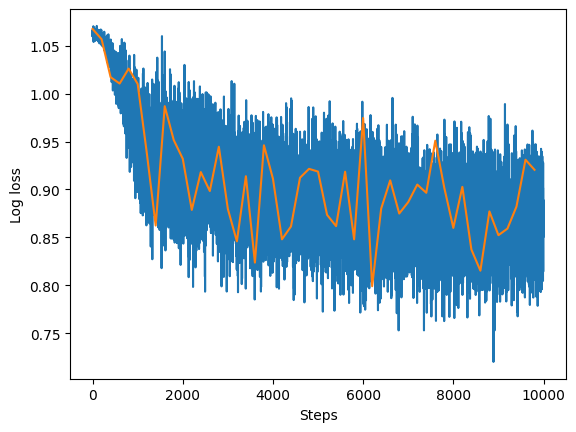

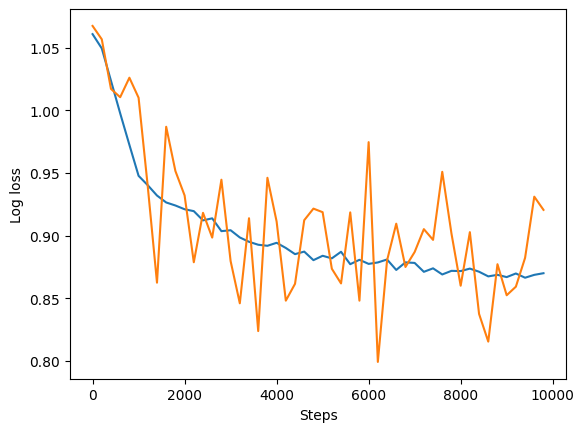

In [ ]:
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist, 1)
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist)

In [ ]:
model.train(False)

generated_tokens = model.generate(input_tokens.unsqueeze(0), max_tokens=100)[0].tolist()
print(tokenizer.decode(generated_tokens).strip())

A car is a  tropical four Auburn cutting Old freeway4 reinforcedb floodA.@ E700 ( for and93 occupied interchange yard  fixedating peak estimated As Big Ham The relate195 a24 a 15 may to- Feder where + started managed destroyed a freeway achieved food tropical The four Feder and9115 charter Colonel one supportedup a cr Boxing traffic159 Feder goalsères disliked after One rainfall minutes finisheduhion third jack flutz Awards traffic % the baseball resulting the proceeds at7 , Ma lead freeway route Lock port


In [33]:
class AttentionHead(nn.Module):
  def __init__(
    self,
    head_size,
    emb_dim,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    self.head_size = head_size

    self.queries = nn.Linear(emb_dim, head_size, bias=False)
    self.keys = nn.Linear(emb_dim, head_size, bias=False)
    self.values = nn.Linear(emb_dim, head_size, bias=False)

    self.register_buffer('decoder_mask', t.tril(t.ones(context_sequence_length, context_sequence_length)))

  def forward(self, x):
    q = self.queries(x)
    k = self.keys(x)
    v = self.values(x)

    attention_weights = q @ k.transpose(-2, -1) * self.head_size**-0.5
    dim = x.shape[1]
    attention_weights = attention_weights.masked_fill(self.decoder_mask[:dim, :dim] == 0, float('-Inf'))
    attention_weights = F.softmax(attention_weights, dim=-1)

    out = attention_weights @ v

    return out

class BasicGPT(nn.Module):

  def __init__(
    self,
    vocab_size,
    emb_dim,
    context_sequence_length,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    self.lookup = nn.Embedding(vocab_size, emb_dim)
    self.pos = nn.Embedding(context_sequence_length, emb_dim)

    self.attention = AttentionHead(emb_dim, emb_dim)
    self.norm_0 = nn.LayerNorm(emb_dim)

    self.hidden_0 = nn.Linear(emb_dim, num_layer_neurons, bias=False)
    self.gelu = nn.GELU()
    self.hidden_1 = nn.Linear(num_layer_neurons, emb_dim)
    self.norm_1 = nn.LayerNorm(emb_dim)

    self.final = nn.Linear(emb_dim, vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    residue = self.pos(t.arange(x.shape[1], device=device)) + x

    x = self.attention(residue)
    x = x + residue
    residue = self.norm_0(x)

    x = self.hidden_0(residue)
    x = self.gelu(x)
    x = self.hidden_1(x)
    x = x + residue
    residue = self.norm_1(x)

    out = self.final(residue)
    return out

  def generate(self, x, max_tokens):
    for _ in range(max_tokens):
      logits = self(x[:, -context_sequence_length:])[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      sample_index = t.multinomial(probs, 1)
      x = t.cat((x, sample_index), dim=1)
    return x

In [17]:
def get_batch(data):
  index = t.randint(len(data) - context_sequence_length - 1, (training_batch_size,))
  x = t.stack([data[i:i+context_sequence_length] for i in index]).to(device)
  y = t.stack([data[i+1:i+context_sequence_length+1] for i in index]).to(device)
  return x, y

In [18]:
# Updated train function

def train(model, iterations):
  # Set to training mode
  model.train(True)

  # Track log-loss reduction
  trn_log_loss_hist = []
  dev_log_loss_hist = []
  trn_step_hist = []
  dev_step_hist = []

  # Define optimizer
  optimizer = t.optim.AdamW(model.parameters(), lr=0.0003)

  # Progress logging period
  log_period = find_best_divisor(iterations)

  for i in range(iterations):
    # Increasing batch size reduces 'noise' when training
    x_batch, y_batch = get_batch(trn)

    #### Forward pass
    logits = model(x_batch)
    X, Y, Z = logits.shape

    loss = F.cross_entropy(logits.view(X * Y, Z), y_batch.view(X * Y))

    # Periodically print training loss
    if i % log_period == 0:
      dev_step_hist.append(i)
      dev_x_batch, dev_y_batch = get_batch(dev)
      validation_logits = model(dev_x_batch)
      X, Y, Z = validation_logits.shape
      validation_loss = F.cross_entropy(validation_logits.view(X * Y, Z), dev_y_batch.view(X * Y))
      dev_log_loss_hist.append(validation_loss.log10().item())
      print(f'Batch: {i:7d} - Training Loss: {loss.item():>.4f} - Validation Loss: {validation_loss.item():>.4f}')

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Update params
    optimizer.step()

    # Track the log-loss
    trn_step_hist.append(i)
    trn_log_loss_hist.append(loss.log10().item())

  return trn_step_hist, trn_log_loss_hist, dev_step_hist, dev_log_loss_hist

In [34]:
# Potato GPU moment
context_sequence_length = 128
emb_dim = 64
num_layer_neurons = 128
learning_iterations = 1000
training_batch_size = 32

# Instantiate model in device
gpt = BasicGPT(vocab_size, emb_dim, context_sequence_length, num_layer_neurons).to(device)

In [ ]:
_, trn_log_loss_hist, dev_step_hist, dev_log_loss_hist = train(gpt, learning_iterations)

Batch:       0 - Training Loss: 11.7042 - Validation Loss: 11.7061
Batch:      50 - Training Loss: 11.1436 - Validation Loss: 11.1401
Batch:     100 - Training Loss: 9.2402 - Validation Loss: 9.2883
Batch:     150 - Training Loss: 7.9856 - Validation Loss: 8.0684
Batch:     200 - Training Loss: 7.5390 - Validation Loss: 7.5930
Batch:     250 - Training Loss: 7.3861 - Validation Loss: 7.3831
Batch:     300 - Training Loss: 7.3828 - Validation Loss: 7.3405
Batch:     350 - Training Loss: 7.4471 - Validation Loss: 7.4631
Batch:     400 - Training Loss: 7.3259 - Validation Loss: 7.3512
Batch:     450 - Training Loss: 7.1810 - Validation Loss: 7.1930
Batch:     500 - Training Loss: 7.0499 - Validation Loss: 7.2241
Batch:     550 - Training Loss: 7.1778 - Validation Loss: 7.1459
Batch:     600 - Training Loss: 7.1504 - Validation Loss: 7.1834
Batch:     650 - Training Loss: 7.1334 - Validation Loss: 7.1887
Batch:     700 - Training Loss: 7.0619 - Validation Loss: 7.1071
Batch:     750 - Trai

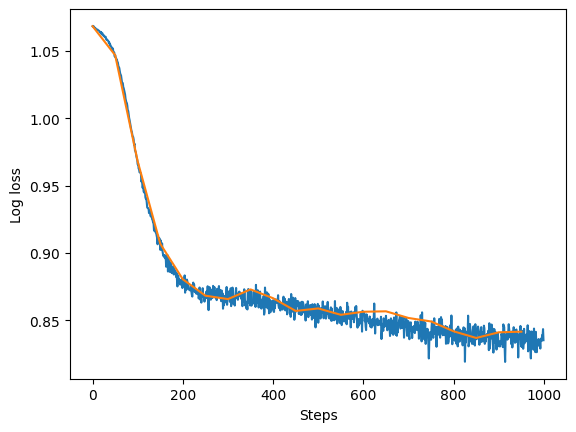

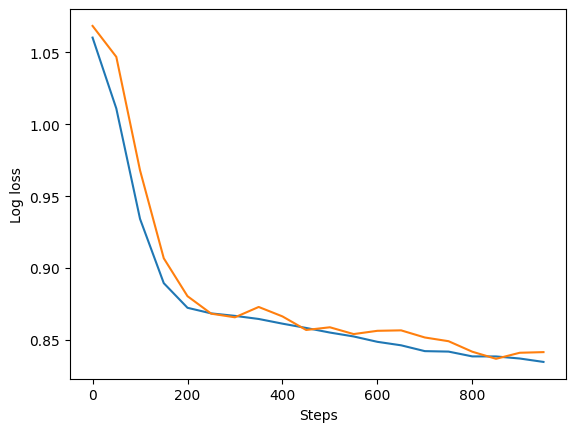

In [ ]:
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist, 1)
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist)

In [ ]:
learning_iterations = 10000

_, trn_log_loss_hist, dev_step_hist, dev_log_loss_hist = train(gpt, learning_iterations)

Batch:       0 - Training Loss: 6.7419 - Validation Loss: 6.9430
Batch:     200 - Training Loss: 6.8176 - Validation Loss: 6.7442
Batch:     400 - Training Loss: 6.5061 - Validation Loss: 6.6059
Batch:     600 - Training Loss: 6.7255 - Validation Loss: 6.6353
Batch:     800 - Training Loss: 6.4541 - Validation Loss: 6.7182
Batch:    1000 - Training Loss: 6.5480 - Validation Loss: 6.6101
Batch:    1200 - Training Loss: 6.3499 - Validation Loss: 6.4622
Batch:    1400 - Training Loss: 6.3548 - Validation Loss: 6.4359
Batch:    1600 - Training Loss: 6.1917 - Validation Loss: 6.6234
Batch:    1800 - Training Loss: 6.3398 - Validation Loss: 6.5832
Batch:    2000 - Training Loss: 6.1280 - Validation Loss: 6.5392
Batch:    2200 - Training Loss: 6.0845 - Validation Loss: 6.4819
Batch:    2400 - Training Loss: 5.9133 - Validation Loss: 6.6757
Batch:    2600 - Training Loss: 6.0441 - Validation Loss: 6.5648
Batch:    2800 - Training Loss: 5.9446 - Validation Loss: 6.2864
Batch:    3000 - Training

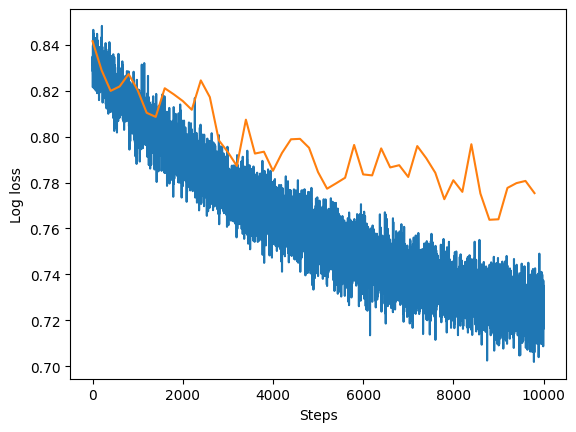

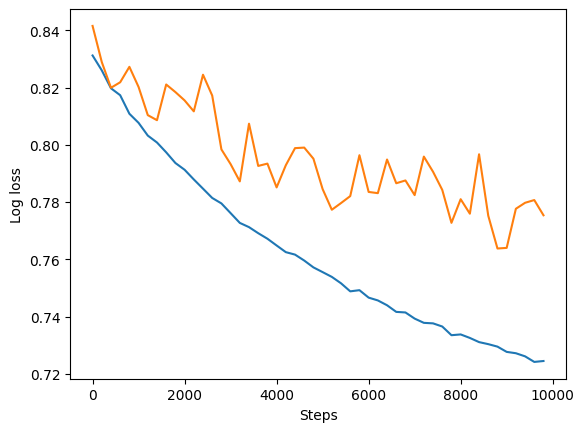

In [ ]:
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist, 1)
plot_log_loss_hist(trn_log_loss_hist, dev_step_hist, dev_log_loss_hist)

In [ ]:
t.save(gpt.state_dict(), 'gpt000.pth')

In [35]:
gpt.load_state_dict(t.load('gpt000.pth'))

<All keys matched successfully>

In [51]:
prompt = 'A car is a '
input_tokens = tokenizer.encode(prompt)
input_tokens = t.tensor(input_tokens, device=device)
print(f'Input:\n{input_tokens}')

Input:
tensor([  32, 1841,  374,  264,  220], device='cuda:0')


In [53]:
gpt.train(False)

generated_tokens = gpt.generate(input_tokens.unsqueeze(0), max_tokens=100)[0].tolist()
print(tokenizer.decode(generated_tokens).strip())

A car is a 9 similar fifth match to await male and broad at least April from Cape Evita ; main reason of the river to ten touchdowns with the appropriate they were eventually altered the name in L. Eliuntristta with her @-@ freeals . There have been built only like Margaret until 5 @,@ 000 investment when the player was not . " and Marcus into a JVmen builds giant is often turned into a run by Kingdom , and isolated with an hour . 

 = = Distribution agon that


In [ ]:
class MultiAttentionHead(nn.Module):
  def __init__(
    self,
    head_count,
    head_size,
    emb_dim
  ):
    super().__init__()
    self.heads = nn.ModuleList([AttentionHead(head_size, emb_dim) for _ in range(head_count)])

  def forward(self, x):
    return t.cat([head(x) for head in self.heads], dim=-1)

class AttentionHead(nn.Module):
  def __init__(
    self,
    head_size,
    emb_dim,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    self.head_size = head_size

    self.queries = nn.Linear(emb_dim, head_size, bias=False)
    self.keys = nn.Linear(emb_dim, head_size, bias=False)
    self.values = nn.Linear(emb_dim, head_size, bias=False)

    self.register_buffer('decoder_mask', t.tril(t.ones(context_sequence_length, context_sequence_length)))

  def forward(self, x):
    q = self.queries(x)
    k = self.keys(x)
    v = self.values(x)

    attention_weights = q @ k.transpose(-2, -1) * self.head_size**-0.5
    dim = x.shape[1]
    attention_weights = attention_weights.masked_fill(self.decoder_mask[:dim, :dim] == 0, float('-Inf'))
    attention_weights = F.softmax(attention_weights, dim=-1)

    out = attention_weights @ v

    return out

class MultiHeadGPT(nn.Module):

  def __init__(
    self,
    vocab_size,
    emb_dim,
    context_sequence_length,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)
    self.lookup = nn.Embedding(vocab_size, emb_dim)
    self.pos = nn.Embedding(context_sequence_length, emb_dim)

    self.attention = MultiAttentionHead(4, emb_dim // 4, emb_dim)
    self.norm_0 = nn.LayerNorm(emb_dim)

    self.hidden_0 = nn.Linear(emb_dim, num_layer_neurons, bias=False)
    self.gelu = nn.GELU()
    self.hidden_1 = nn.Linear(num_layer_neurons, emb_dim)
    self.norm_1 = nn.LayerNorm(emb_dim)

    self.final = nn.Linear(emb_dim, vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    residue = self.pos(t.arange(x.shape[1], device=device)) + x

    x = self.attention(residue)
    x = x + residue
    residue = self.norm_0(x)

    x = self.hidden_0(residue)
    x = self.gelu(x)
    x = self.hidden_1(x)
    x = x + residue
    residue = self.norm_1(x)

    out = self.final(residue)
    return out

  def generate(self, x, max_tokens):
    for _ in range(max_tokens):
      logits = self(x[:, -context_sequence_length:])[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      sample_index = t.multinomial(probs, 1)
      x = t.cat((x, sample_index), dim=1)
    return x

## Example: "WaveNet" structure implementation

In [ ]:
class GroupEmbedding(nn.Module):
  def __init__(self, factor: int = 2):
    super().__init__()
    self.factor = factor

  def forward(self, input: t.Tensor):
    shape = input.shape
    input = input.view(shape[0], -1, shape[-1] * self.factor)
    return input if input.shape[-2] != 1 else input.squeeze(-2)

  def extra_repr(self) -> str:
    return f'factor={self.factor}'

class WaveNet(nn.Module):

  def __init__(
    self,
    vocab_size,
    emb_dim,
    input_block_size,
    group_size,
    num_layer_neurons,
    *args,
    **kwargs
  ):
    super().__init__(*args, **kwargs)

    self.lookup = nn.Embedding(vocab_size, emb_dim)

    input_block_size //= group_size
    self.block_0 = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * emb_dim, num_layer_neurons, bias=False),
      nn.BatchNorm1d(input_block_size),
      nn.Tanh(),
    )

    input_block_size //= group_size
    self.block_1 = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * num_layer_neurons, num_layer_neurons, bias=False),
      nn.BatchNorm1d(input_block_size),
      nn.Tanh(),
    )

    self.last_block = nn.Sequential(
      GroupEmbedding(group_size),
      nn.Linear(group_size * num_layer_neurons, num_layer_neurons, bias=False),
      nn.BatchNorm1d(num_layer_neurons),
      nn.Tanh(),
    )

    self.final = nn.Linear(num_layer_neurons, vocab_size)

  def forward(self, x):
    x = self.lookup(x)
    x = self.block_0(x)
    x = self.block_1(x)
    x = self.last_block(x)
    x = self.final(x)
    return x

In [ ]:
# Increase block size

input_block_size = 8

In [ ]:
# Rebuild dataset

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrn, Ytrn = build_dataset(words[:n1], input_block_size)
Xdev, Ydev = build_dataset(words[n1:n2], input_block_size)
Xtes, Ytes = build_dataset(words[n2:], input_block_size)

torch.Size([182427, 8]) torch.Size([182427])
torch.Size([22852, 8]) torch.Size([22852])
torch.Size([22867, 8]) torch.Size([22867])


In [ ]:
basic_model = model

In [ ]:
# Instantiate model in device

group_size = 2  # (cubic root of 8)

model = WaveNet(vocab_size, emb_dim, input_block_size, group_size, num_layer_neurons)
model = model.to(device)

In [ ]:
model

WaveNet(
  (lookup): Embedding(27, 10)
  (block_0): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=20, out_features=200, bias=False)
    (2): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (block_1): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=400, out_features=200, bias=False)
    (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (last_block): Sequential(
    (0): GroupEmbedding(factor=2)
    (1): Linear(in_features=400, out_features=200, bias=False)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Tanh()
  )
  (final): Linear(in_features=200, out_features=27, bias=True)
)

Batch:       0 - Loss: 3.3560593128204346
Batch:   15000 - Loss: 2.094456434249878
Batch:   30000 - Loss: 2.287414073944092
Batch:   45000 - Loss: 2.157564163208008
Batch:   60000 - Loss: 2.0257408618927
Batch:   75000 - Loss: 1.7671853303909302
Batch:   90000 - Loss: 1.6970891952514648
Batch:  105000 - Loss: 1.9333022832870483
Batch:  120000 - Loss: 1.8882107734680176
Batch:  135000 - Loss: 2.167881727218628
Batch:  150000 - Loss: 2.1600329875946045
Batch:  165000 - Loss: 1.7912647724151611
Training loss   = 1.7794862985610962
Validation loss = 2.0236449241638184
Testing loss    = 2.0272936820983887


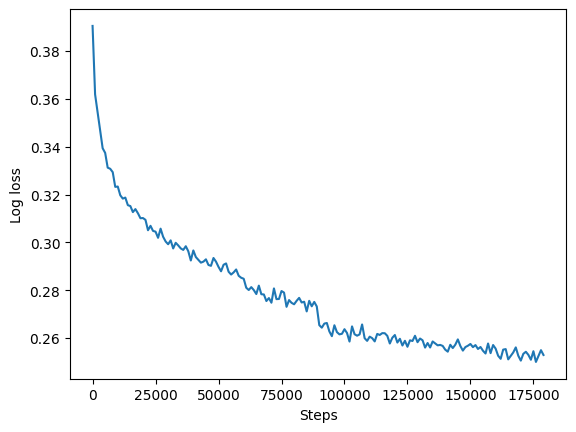

In [ ]:
reset_train_eval()

In [ ]:
predict(69)

['janella', 'milee', 'oluwamaria', 'tannleigh', 'brandon', 'aakin', 'renity', 'jenoni', 'eyzlene', 'avonni', 'khyree', 'kealani', 'aubitha', 'nivellah', 'cecen', 'ahmir', 'gabeth', 'kimiah', 'lauron', 'jaspen', 'zurimylazi', 'ezekiel', 'regdan', 'jaron', 'keanna', 'anabee', 'neffaan', 'rhyle', 'laurianna', 'desankida']
